# Obtención y preprocesado de datos

In [1]:
import pandas as pd
import json
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.probability import FreqDist
from funciones import get_sent_tokens,get_lemma,get_stems,remove_stop_words,get_word_tokens, remove_special_characters
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, CategoricalDistribution,LogUniformDistribution

data = pd.read_csv("../data/BooksDataSet.csv").drop(columns=['Unnamed: 0'])
data

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alvaro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\Alvaro\Desktop\BookGenreDetector\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,book_id,book_name,genre,summary
0,3248537,Drowned Wednesday,Fantasy,Drowned Wednesday is the first Trustee among ...
1,27796919,The Lost Hero,Fantasy,"As the book opens, Jason awakens on a school ..."
2,3910776,The Eyes of the Overworld,Fantasy,Cugel is easily persuaded by the merchant Fia...
3,5969644,Magic's Promise,Fantasy,The book opens with Herald-Mage Vanyel return...
4,3173445,Taran Wanderer,Fantasy,Taran and Gurgi have returned to Caer Dallben...
...,...,...,...,...
2995,10372180,White Death,Thriller,"A Novel from the NUMA files, A Kurt Austin Ad..."
2996,14504372,Venus with Pistol,Thriller,Gilbert Kemp is dealer specializing in antiqu...
2997,3617412,Blackwater,Thriller,"""How do you know when you're in too deep? Dav..."
2998,11320975,The Rainbow and the Rose,Thriller,The story concerns the life of Johnnie Pascoe...


In [2]:
data.isnull().sum()

book_id      0
book_name    0
genre        0
summary      0
dtype: int64

In [3]:
data.genre.value_counts()

genre
Fantasy             500
Science Fiction     500
Crime Fiction       500
Historical novel    500
Horror              500
Thriller            500
Name: count, dtype: int64

In [4]:
def summary_processing(row):
    summary = row["summary"]
    get_stems(summary)
    

In [5]:
a = data.summary[0]
#tokenizacion de frases
sentences = get_sent_tokens(a)
#quitamos caracteres especiales
clean = remove_special_characters(sentences)
#tokenizacion de palabras
words = get_word_tokens(clean)
#stemming
stems = get_stems(words)
#lemmatization
lemma = get_lemma(stems)
#quitamos stopwords
pre = remove_stop_words(lemma)
pre

['drown',
 'wednesday',
 'first',
 'truste',
 'among',
 'morrow',
 'day',
 'arthur',
 'side',
 'wish',
 'fulfil',
 'appear',
 'leviathanwhal',
 'suffer',
 'gluttoni',
 'book',
 'begin',
 'leaf',
 'visit',
 'arthur',
 'discus',
 'invit',
 'drown',
 'wednesday',
 'sent',
 'arthur',
 'admit',
 'hospit',
 'becaus',
 'damag',
 'done',
 'hi',
 'leg',
 'attempt',
 'enter',
 'tuesday',
 'treasur',
 'tower',
 'suddenli',
 'hospit',
 'room',
 'becom',
 'flood',
 'water',
 'two',
 'transport',
 'border',
 'sea',
 'hous',
 'leaf',
 'snatch',
 'away',
 'larg',
 'ship',
 'green',
 'sail',
 'known',
 'fli',
 'manti',
 'arthur',
 'remain',
 'hi',
 'bed',
 'medallion',
 'given',
 'immort',
 'call',
 'marin',
 'appar',
 'fail',
 'summon',
 'help',
 'arthur',
 'without',
 'hope',
 'eventu',
 'buoy',
 'mark',
 'pirat',
 'elishar',
 'feverfew',
 'treasur',
 'float',
 'toward',
 'soon',
 'arthur',
 'open',
 'hi',
 'hand',
 'mark',
 'bloodi',
 'red',
 'colour',
 'arthur',
 'ha',
 'red',
 'hand',
 'feverfew',

In [6]:
def process_summary(summary):
    #tokenizacion de frases
    sentences = get_sent_tokens(summary)
    #quitamos caracteres especiales
    clean = remove_special_characters(sentences)
    #tokenizacion de palabras
    words = get_word_tokens(clean)
    #stemming
    stems = get_stems(words)
    #lemmatization
    lemma = get_lemma(stems)
    #quitamos stopwords
    pre = remove_stop_words(lemma)
    return ' '.join(pre)

data['summary'] = data['summary'].apply(lambda x: process_summary(x))

In [7]:
data

,book_id,book_name,genre,summary
0,3248537,Drowned Wednesday,Fantasy,drown wednesday first truste among morrow day ...
1,27796919,The Lost Hero,Fantasy,book open jason awaken school bu unabl rememb ...
2,3910776,The Eyes of the Overworld,Fantasy,cugel easili persuad merchant fianosth attempt...
3,5969644,Magic's Promise,Fantasy,book open heraldmag vanyel return hi countri v...
4,3173445,Taran Wanderer,Fantasy,taran gurgi return caer dallben follow event t...
...,...,...,...,...
2995,10372180,White Death,Thriller,novel numa file kurt austin adventur thi novel...
2996,14504372,Venus with Pistol,Thriller,gilbert kemp dealer special antiqu gun london ...
2997,3617412,Blackwater,Thriller,know deep davey ha alway live shadow hi older ...
2998,11320975,The Rainbow and the Rose,Thriller,stori concern life johnni pasco retir commerci...


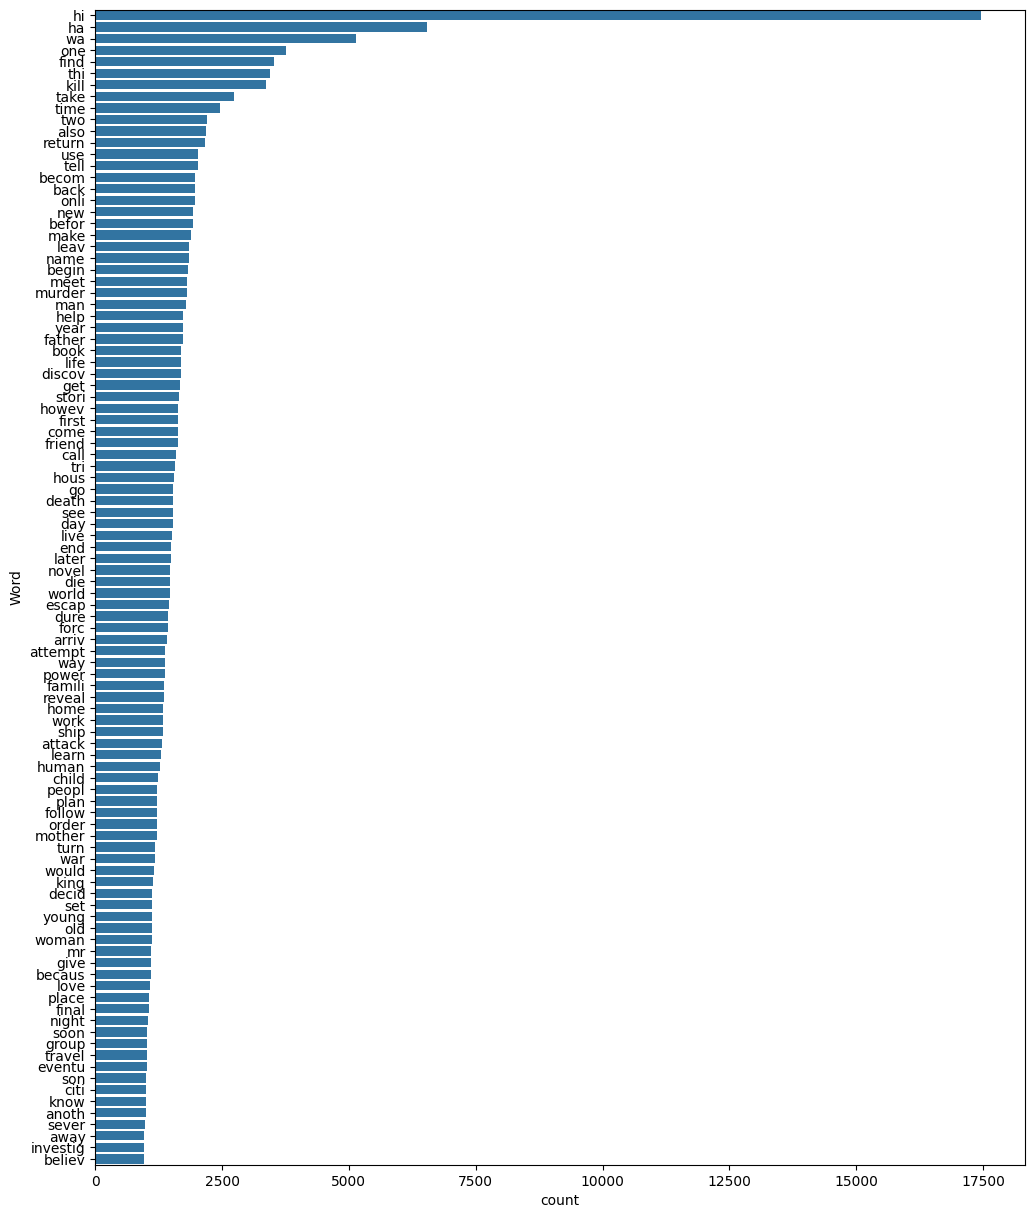

In [8]:

#mostramos las 100 palabras mas comunes entre todos los libros
def plot_most_frequent_words(words, num_words=100):
    # Create a frequency distribution of the words
    freq_dist = FreqDist(words)
    
    # Select the top 'num_words' most frequent words
    wordsdf = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())}) 
    top_words = wordsdf.sort_values(by='count', ascending=False).iloc[0:100]
    
    # Plotting
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=top_words, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()
    
plot_most_frequent_words(' '.join(list(data.summary)).split(' '), num_words=100)

# Features

In [9]:
#usamos label encoder para codificar cada género

LE = LabelEncoder()
y=LE.fit_transform(data['genre'])
dict(zip(LE.classes_,LE.transform(LE.classes_)))

{'Crime Fiction': 0,
 'Fantasy': 1,
 'Historical novel': 2,
 'Horror': 3,
 'Science Fiction': 4,
 'Thriller': 5}

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data['summary'], y, test_size=0.2, random_state=557) 

In [11]:
#aplicamos tf-idf para poder pasarlo a los modelos
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer() # se ha visto que funciona mejor sin limtar el max_df ni el max_features

# Fit and transform the documents
tf_train  = tfidf_vectorizer.fit_transform(X_train)

# Convert the TF-IDF matrix to a pandas DataFrame
tf_test = tfidf_vectorizer.transform(X_test)



In [12]:
def apply_tfidf(string):
    tfidf_vectorizer = TfidfVectorizer() # se ha visto que funciona mejor sin limtar el max_df ni el max_features
    # Fit and transform the documents
    tf_train  = tfidf_vectorizer.fit_transform(X_train)
    # Convert the TF-IDF matrix to a pandas DataFrame
    tf_test = tfidf_vectorizer.transform(string)
    return tf_test
    

# Modelos

## Random Forest

In [ ]:
# param_grid = {
#     'n_estimators': IntDistribution(low=100,high=500,step=50),
#     'max_depth': IntDistribution(low=1, high=31, step=5),
#     'min_samples_split': IntDistribution(1,30,5),
#     'min_samples_leaf': IntDistribution(1,30,5),
#     'max_features': CategoricalDistribution(['auto','sqrt', .9, .75])
# }
# rf = RandomForestClassifier()

# optuna = OptunaSearchCV(
#     estimator=rf,
#     param_distributions=param_grid,
#     n_trials=40,
#     timeout=10*60,
#     cv=5,
#     random_state=99,
#     n_jobs=-1,
#     verbose=False
# )
# # fit model on train data.
# optuna.fit(tf_train, y_train)

# print("Best parameters found: ", optuna.best_params_)
# print("Best score found: ", optuna.best_score_)
# rf = optuna.best_estimator_

C:\Users\Alvaro\AppData\Local\Temp\ipykernel_19816\2056841273.py:10: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna = OptunaSearchCV(
[I 2024-04-04 16:29:25,583] A new study created in memory with name: no-name-cdd0efe1-cc57-4744-98a7-c651e960a8c4
c:\Users\Alvaro\Desktop\BookGenreDetector\venv\Lib\site-packages\optuna_integration\sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
c:\Users\Alvaro\Desktop\BookGenreDetector\venv\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[W 2024-04-04 16:29:25,810] Trial 2 failed with parameters: {'n_estimators': 200, 'max_depth': 21, 'min_samples_split': 1, 'min_samples_leaf': 1, 'max_features': 'sqrt'} because of the following error: The value nan is not acceptable.
[W 2024-04-04 16:29:25,812

Best parameters found:  {'n_estimators': 250, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best score found:  0.6491666666666667


In [16]:
#guardamos los resultados para poder recuperarlo sin ejecutar todo
# import pickle
# with open("rf.pkl", 'wb') as f:
#     pickle.dump(optuna, f)

In [13]:
import pickle
with open("rf.pkl", 'rb') as f:
    optuna = pickle.load(f)

In [14]:
optuna

OptunaSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1, n_trials=40,
               param_distributions={'max_depth': IntDistribution(high=31, log=False, low=1, step=5),
                                    'max_features': CategoricalDistribution(choices=('auto', 'sqrt', 0.9, 0.75)),
                                    'min_samples_leaf': IntDistribution(high=30, log=5, low=1, step=1),
                                    'min_samples_split': IntDistribution(high=30, log=5, low=1, step=1),
                                    'n_estimators': IntDistribution(high=500, log=False, low=100, step=50)},
               random_state=99, timeout=600, verbose=False)

In [15]:
rf = optuna.best_estimator_

In [16]:
# make predictions for validation set.
y_pred = rf.predict(tf_test)

#Calculating the accuracy.
print( 'Accuracy Score :',accuracy_score(y_test,y_pred) )

#Printing the classification report.
print ('Report : ')
print(classification_report(y_test,y_pred))

Accuracy Score : 0.6616666666666666
Report : 
              precision    recall  f1-score   support

           0       0.54      0.83      0.65       102
           1       0.60      0.65      0.62        89
           2       0.79      0.70      0.74       110
           3       0.78      0.63      0.70       100
           4       0.71      0.70      0.70        97
           5       0.66      0.45      0.53       102

    accuracy                           0.66       600
   macro avg       0.68      0.66      0.66       600
weighted avg       0.68      0.66      0.66       600



## Logistic Regression

In [ ]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

# fit model on train data.
clf.fit(tf_train, y_train)

# make predictions for validation set.
y_pred_lr = clf.predict(tf_test)

#Calculating the accuracy.
print( 'Accuracy Score :',accuracy_score(y_test,y_pred_lr))

#Printing the classification report.
print ('Report : ')
print(classification_report(y_test,y_pred_lr))

Accuracy Score : 0.7916666666666666
Report : 
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       102
           1       0.73      0.79      0.76        89
           2       0.82      0.88      0.85       110
           3       0.79      0.76      0.78       100
           4       0.83      0.78      0.80        97
           5       0.78      0.71      0.74       102

    accuracy                           0.79       600
   macro avg       0.79      0.79      0.79       600
weighted avg       0.79      0.79      0.79       600



In [ ]:
tf_test

<600x35870 sparse matrix of type '<class 'numpy.float64'>'
	with 93588 stored elements in Compressed Sparse Row format>

In [ ]:
import numpy as np
print(clf.predict(apply_tfidf(["space time is flexible when dealing with aliens in space"]))) #tiene sentido que sea ciencia ficción
print(clf.predict(apply_tfidf(["The detective wasn't sure if the crime would be solvable"]))) #tiene sentido que sea crimen

[4]
[0]


Accuracy Score : 0.6383333333333333
Report : 
              precision    recall  f1-score   support

           0       0.53      0.77      0.63       102
           1       0.58      0.70      0.64        89
           2       0.78      0.72      0.75       110
           3       0.70      0.51      0.59       100
           4       0.70      0.76      0.73        97
           5       0.58      0.37      0.46       102

    accuracy                           0.64       600
   macro avg       0.65      0.64      0.63       600
weighted avg       0.65      0.64      0.63       600



## SVM

In [22]:
# from sklearn.svm import SVC

# from optuna.integration import OptunaSearchCV
# from optuna.distributions import IntDistribution, CategoricalDistribution,FloatDistribution

# param_grid = {
#     "C": CategoricalDistribution([.1, 1, 10, 100, 1000]),
#     "kernel": CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
#     "degree": IntDistribution(0, 5),
#     "gamma": CategoricalDistribution(["auto","scale"]),
#     "shrinking": CategoricalDistribution([True, False]),
#     "probability": CategoricalDistribution([True, False])
# }
# svc = SVC()

# rs = OptunaSearchCV(
#     estimator=svc,
#     param_distributions=param_grid,
#     n_trials=100,
#     cv=5,
#     random_state=99,
#     n_jobs=-1,
#     verbose=False
# )
# # fit model on train data.
# rs.fit(tf_train, y_train)


C:\Users\Alvaro\AppData\Local\Temp\ipykernel_5904\2756469061.py:16: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  rs = OptunaSearchCV(
[I 2024-04-04 23:17:14,577] A new study created in memory with name: no-name-aeb8aeea-069d-463c-95d0-a2c7050be6a8
[I 2024-04-04 23:17:49,452] Trial 10 finished with value: 0.33625000000000005 and parameters: {'C': 100, 'kernel': 'poly', 'degree': 4, 'gamma': 'scale', 'shrinking': False, 'probability': False}. Best is trial 10 with value: 0.33625000000000005.
[I 2024-04-04 23:17:49,995] Trial 4 finished with value: 0.7004166666666667 and parameters: {'C': 1000, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 'scale', 'shrinking': True, 'probability': False}. Best is trial 4 with value: 0.7004166666666667.
[I 2024-04-04 23:17:51,057] Trial 9 finished with value: 0.7095833333333333 and parameters: {'C': 1, 'kernel': 'sigmoid', 'degree': 2, 'gamma': 'scale', 'shrinking': False, 'probabilit

Best parameters found:  {'C': 1, 'kernel': 'sigmoid', 'degree': 2, 'gamma': 'scale', 'shrinking': False, 'probability': False}
Best score found:  0.7095833333333333


In [23]:
# len(rs.trials_)

100

In [24]:
# guardamos los resultados para poder recuperarlo sin ejecutar todo
# import pickle
# with open("svc.pkl", 'wb') as f:
#     pickle.dump(rs, f)

In [25]:
import pickle
with open("svc.pkl", 'rb') as f:
    rs = pickle.load(f)

In [26]:
print("Best parameters found: ", rs.best_params_)
print("Best score found: ", rs.best_score_)
svc = rs.best_estimator_


Best parameters found:  {'C': 1, 'kernel': 'sigmoid', 'degree': 2, 'gamma': 'scale', 'shrinking': False, 'probability': False}
Best score found:  0.7095833333333333


In [27]:
# make predictions for validation set.
y_pred = svc.predict(tf_test)

#Calculating the accuracy.
print( 'Accuracy Score :',accuracy_score(y_test,y_pred) )

#Printing the classification report.
print ('Report : ')
print(classification_report(y_test,y_pred))

Accuracy Score : 0.7783333333333333
Report : 
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       102
           1       0.71      0.75      0.73        89
           2       0.81      0.86      0.84       110
           3       0.77      0.75      0.76       100
           4       0.83      0.79      0.81        97
           5       0.73      0.73      0.73       102

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.78      0.78      0.78       600



## RNNs

### Bag of words

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0.0,max_df=1.0,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(X_train)
#transformed test reviews
cv_test_reviews=cv.transform(X_test)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (2400, 1142068)
BOW_cv_test: (600, 1142068)
